In [45]:
from skimage.color import rgb2ycbcr, rgb2lab, rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from typing import Dict
from scipy.fftpack import dct
from skimage.metrics import peak_signal_noise_ratio as PSNR
import os

def sub2ind(n_row, row, col):
  return n_row * col + row

def dctmtx(N):
  return dct(np.eye(N), norm='ortho', axis=0)

def func(x, mat):
  return mat @ x @ mat.T

def func1(x, mat):
  return np.multiply(mat, x)

def blockproc(im, mat, block_sz, func):
    h, w = im.shape
    m, n = block_sz
    im_out = np.zeros_like(im)
    for x in range(0, h, m):
        for y in range(0, w, n):
            block = im[x:x+m, y:y+n]
            im_out[x:x+m, y:y+n] = func(block, mat)
    return im_out

def plot_images(images: Dict[str, np.ndarray], title=None, cmap='None'):
    """Plots all images in a row""",
    fig = plt.figure(figsize=(10, 3))
    for index, (subtitle, image) in enumerate(images.items(), 1):
        ax = fig.add_subplot(1, len(images), index)
        if cmap == 'gray':
            ax.imshow(image, cmap='gray')
        else:
            ax.imshow(image)
        ax.title.set_text(subtitle)
    if title:
        fig.suptitle(title)
    plt.show()
    

# Part 2 Chroma Subsampling

(384, 512, 3)


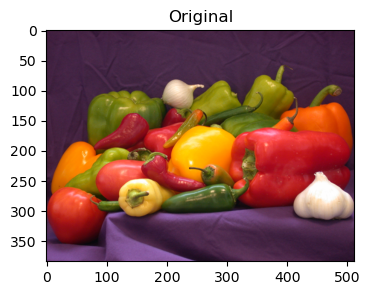

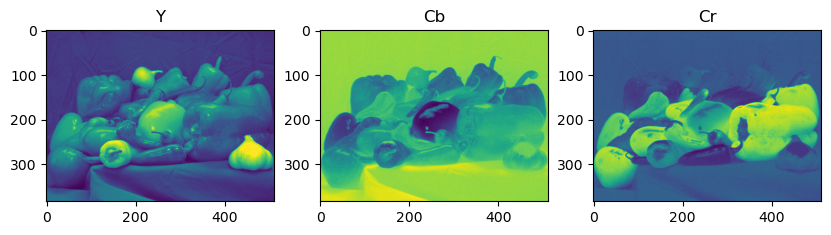

(192, 256) (192, 256)


In [2]:
# code for chroma subsampling
# First, we will study the effects of chroma subsampling on image quality and how it can be used to provide
# image compression. For this study, we will use the peppers image. 

# First, let us convert the image from the RGB colorspace into the YCbCr colorspace using the rgb2ycbcr function from skimage.color. 
peppers = imread('peppers.png')
peppers_ycbcr = rgb2ycbcr(peppers)
print(peppers_ycbcr.shape)

plot_images({'Original': peppers})

# Plot each of the image channels (Y, Cb, and Cr) separately.
y_channel = peppers_ycbcr[:, :, 0]
cb_channel = peppers_ycbcr[:, :, 1]
cr_channel = peppers_ycbcr[:, :, 2]

plot_images({'Y': y_channel, 'Cb': cb_channel, 'Cr': cr_channel})

# Now, reduce the resolution of the chroma channels by a factor of 2 in both the horizontal and vertical
# directions and then upsample them back to the original resolution using bilinear interpolation. The resize
# function from skimage.transform will come in handy. 

# Reduce the resolution of the chroma channels by a factor of 2 in both the horizontal and vertical directions
cb_channel_subsampled = cb_channel[::2, ::2]
cr_channel_subsampled = cr_channel[::2, ::2]

print(cb_channel_subsampled.shape, cr_channel_subsampled.shape)

# Also, you will need to separate the color image
# into three separate images so you can operate on them independently. Recombine the original Y channel
# image and the two upsampled Cb and Cr images to create a new color image. This can be considered
# a simple way of reducing network bandwidth for image/video transfer – that is, downscaling the chroma
# images on the server, sending them over a network to a client, and rescaling on the client.
cb_channel_upsampled = cb_channel_subsampled.repeat(2, axis=0).repeat(2, axis=1)
cr_channel_upsampled = cr_channel_subsampled.repeat(2, axis=0).repeat(2, axis=1)


# Separate the color image into three separate images so you can operate on them independently

# Recombine the original Y channel image and the two upsampled Cb and Cr images to create a new color image

# Reduce the resolution of the luma (Y) channel by a factor
# of 2 in both the horizontal and vertical directions and then upsample it back to the original resolution using
# bilinear interpolation. 

# Recombine the upsampled Y channel image and the original Cb and Cr images to create a new color image.

# Part 3 Colour Segmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


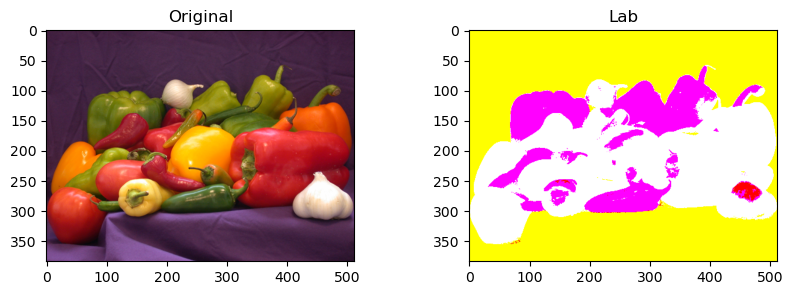

c:\Users\Cooper\miniconda3\envs\syde575\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Cooper\miniconda3\envs\syde575\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


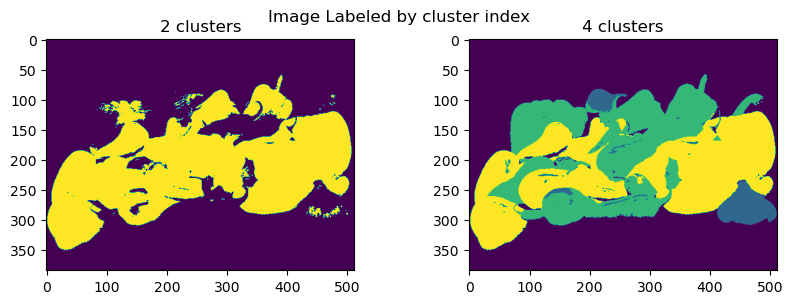

c:\Users\Cooper\miniconda3\envs\syde575\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


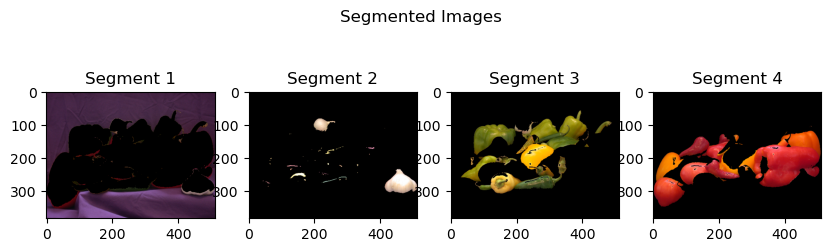

In [66]:
# part 3 Colour Segmentation
# os.environ['OMP_NUM_THREADS'] = '1'
# OMP_NUM_THREADS=1
# 1. convert the image to the lab colorspace
lab_peppers = rgb2lab(peppers)
# 2. use kmeans to cluster the image into 2 and 4 clusters

k2 = 2
k4 = 4
plot_images({'Original': peppers, 'Lab': lab_peppers}, cmap=None)

# get the cluster centers
row2 = np.array([55, 200]) - 1
col2 = np.array([155, 400]) - 1
row4 = np.array([55, 130, 200, 280]) - 1
col4 = np.array([155, 110, 400, 470]) - 1
mu1 = lab_peppers[row2, col2]
mu2 = lab_peppers[row4, col4]
kmeans2 = KMeans(n_clusters=k2, n_init=10, random_state=0).fit(mu1)
kmeans4 = KMeans(n_clusters=k4, n_init=10, random_state=0).fit(mu2)

# reshape the image into a 2D array
m, n, ch = lab_peppers.shape
lab_peppers = np.reshape(lab_peppers, (m*n, ch), order='F')

# get the cluster indices
cluster2 = kmeans2.predict(lab_peppers)
cluster4 = kmeans4.predict(lab_peppers)

pixel_labels2 = np.reshape(cluster2, (m, n), order='F')
pixel_labels4 = np.reshape(cluster4, (m, n), order='F')


# plot with jet colormap, and title 'Image Labeled by cluster index'
plot_images({'2 clusters': pixel_labels2, '4 clusters': pixel_labels4}, title='Image Labeled by cluster index', cmap='jet')

# plot the segmented images

def plot_segments(image, k, row, col):
  image_lab = rgb2lab(image)
  mu = image_lab[row, col]

  for i in range(k):
    mu[i] = image_lab[row[i] - 1, col[i] -1]

  m, n, ch = image_lab.shape
  reshaped_image = np.reshape(image_lab, (m*n, ch), order='F')
  kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(mu)
  cluster = kmeans.predict(reshaped_image)
  pixel_labels = np.reshape(cluster, (m, n), order='F')

  segmented_images = {}

  for label in range(k):
    mask = (pixel_labels == label)
    masked_image = np.zeros_like(image)
    masked_image[mask] = image[mask]
    segmented_images[f'Segment {label+1}'] = masked_image


  plot_images(segmented_images, title='Segmented Images')

      

  
plot_segments(peppers, 4, row4, col4)





# I am not sure if the above instructions are correct. Please check and correct them if necessary.

# Part 4 Image Transform

In [4]:
# Part 4 Image Transform

# NOTE from cormo: make sure to scale the image (lena) by 255 after importing it

# In this part, we will perform an image transform using the Discrete Cosine Transform (DCT).
# The DCT is a widely used transform in image and video compression.

# 1. Load the image using the imread() function from the skimage.io module.
# 2. Convert the image to grayscale using the rgb2gray() function from the skimage.color module.
# 3. Apply the DCT to the grayscale image using the dct() function from the scipy.fftpack module.
#    Set the `norm` parameter to 'ortho' and the `axis` parameter to 0.
# 4. Calculate the magnitude spectrum of the DCT coefficients using the np.abs() function.
# 5. Display the magnitude spectrum using the plt.imshow() function from the matplotlib.pyplot module.
# 6. Apply a threshold to the magnitude spectrum to remove low-frequency components.
#    Set a threshold value based on your observation of the magnitude spectrum.
# 7. Set the low-frequency components to zero in the DCT coefficients.
# 8. Apply the inverse DCT to the modified DCT coefficients using the idct() function from the scipy.fftpack module.
#    Set the `norm` parameter to 'ortho' and the `axis` parameter to 0.
# 9. Display the reconstructed image using the plt.imshow() function.
# 10. Calculate the Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images
#     using the PSNR() function from the skimage.metrics module.
#     Print the PSNR value to evaluate the quality of the reconstructed image.

# Make sure to import the necessary modules and functions before executing the code.

# not sure if the above instructions are correct. Please check and correct them if necessary.

# Part 5 Quantization 

In [5]:
# Part 5 Quantization

# In this part, we will perform quantization on the image using a quantization table.
# The quantization table is a matrix that determines the level of compression applied to different frequency components of the image.

# 1. Load the image using the imread() function from the skimage.io module.
# 2. Convert the image to grayscale using the rgb2gray() function from the skimage.color module.
# 3. Apply the DCT to the grayscale image using the dct() function from the scipy.fftpack module.
#    Set the `norm` parameter to 'ortho' and the `axis` parameter to 0.
# 4. Define a quantization table as a 2D array of integers.
#    The quantization table determines the level of compression applied to different frequency components.
#    You can experiment with different quantization tables to achieve different levels of compression.
# 5. Divide the DCT coefficients by the quantization table.
#    This step quantizes the coefficients and reduces the precision of the image.
# 6. Multiply the quantized DCT coefficients by the quantization table.
#    This step dequantizes the coefficients and restores the precision of the image.
# 7. Apply the inverse DCT to the modified DCT coefficients using the idct() function from the scipy.fftpack module.
#    Set the `norm` parameter to 'ortho' and the `axis` parameter to 0.
# 8. Display the reconstructed image using the plt.imshow() function.
# 9. Calculate the Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images
#    using the PSNR() function from the skimage.metrics module.
#    Print the PSNR value to evaluate the quality of the reconstructed image.

# Make sure to import the necessary modules and functions before executing the code.

# Note: The quantization table can be customized to achieve different levels of compression.
# Higher values in the quantization table result in more compression and lower image quality,
# while lower values result in less compression and higher image quality.

# not sure if the above instructions are correct. Please check and correct them if necessary.

# Part 6 Convolutional Neural Networks 

In [6]:
# Part 6 Convolutional Neural Networks

# In this part, we will build a Convolutional Neural Network (CNN) for image classification.
# The CNN will be trained on a dataset of images and will learn to classify new images into different categories.

# 1. Import the necessary modules and libraries for building the CNN.
# 2. Load the dataset of images for training and testing.
# 3. Preprocess the images by resizing them to a fixed size and normalizing the pixel values.
# 4. Split the dataset into training and testing sets.
# 5. Define the architecture of the CNN.
#    This includes specifying the number and size of convolutional layers, pooling layers, and fully connected layers.
# 6. Compile the CNN by specifying the loss function, optimizer, and evaluation metric.
# 7. Train the CNN on the training set.
#    This involves feeding the training images through the network, computing the loss, and updating the network weights.
# 8. Evaluate the performance of the trained CNN on the testing set.
#    This involves feeding the testing images through the network and computing the accuracy.
# 9. Optionally, fine-tune the CNN by adjusting the hyperparameters or architecture.
# 10. Save the trained CNN model for future use.

# Make sure to import the necessary modules and libraries before executing the code.

# Note: Building and training a CNN can be computationally intensive.
# It is recommended to run the code on a machine with a GPU for faster training.

# not sure if the above instructions are correct. Please check and correct them if necessary.